# Walmart Demand Forecasting

We will perform some simple demand forecasting using Walmart's quarterly revenue figures. These figures were adapted from Walmart's quarterly financial reports from FY 2010 to 2018. 

The techniques used for forecasting are simple, double and triple exponential smoothing.

## Time Series Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('walmart_rev.csv')

In [3]:
split_ix = 28
train_ix = range(0, 28)
test_ix = range(28, 34)

ts = pd.Series(df['revenue_millions'])
train = pd.Series(df['revenue_millions'][:split_ix], index=train_ix)
test = pd.Series(df['revenue_millions'][split_ix:], index=test_ix)

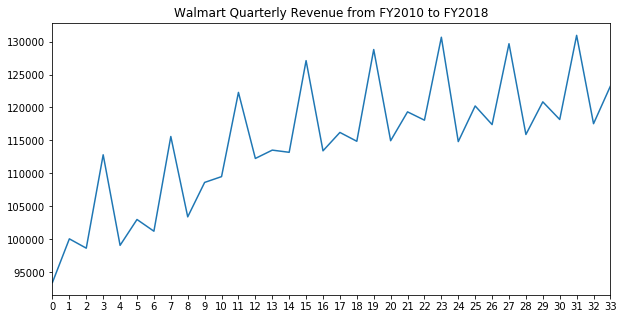

In [4]:
ts.plot(figsize=(10,5), title='Walmart Quarterly Revenue from FY2010 to FY2018')
plt.xticks(range(0, 34, 1))
plt.show()

It would appear that there is level, trend and seasonality that exists in Walmart's quarterly earnings over the past 8 years.

An **increasing trend** seems to occur within this time period, however the rate of increase begins to decrease around the start of FY 2015 (index 20); trend starts to plateau.

There is also a **strong seasonality** pattern due to expected consumer behaviour which happens throughout the year due to yearly affairs. For example, there is always a peak in revenue figures in Q4 because of holiday events like Black Friday, Christmas and New Year's which take place around year's end.

## Simple Exponential Smoothing

In [5]:
def exp_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [6]:
es1 = exp_smoothing(ts, 0.9)
es1_test = pd.Series(es1[split_ix:], index=test_ix)

### Error Metrics & Test Set Plot

In [7]:
from sklearn.metrics import mean_absolute_error
es1_mae = mean_absolute_error(test, es1_test)
print('The MAE for simple exponential smoothing on the test set is %.2f' %es1_mae)

The MAE for simple exponential smoothing on the test set is 795.46


In [8]:
from sklearn.metrics import mean_squared_error
es1_mse = mean_squared_error(test, es1_test)
print('The MSE for simple exponential smoothing on the test set is %.2f' %es1_mse)

The MSE for simple exponential smoothing on the test set is 835520.56


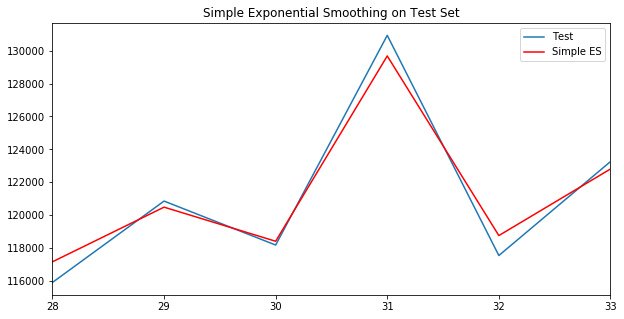

In [9]:
test.plot(figsize=(10,5), label='Test', legend=True)
es1_test.plot(figsize=(10,5), color='r', label='Simple ES', legend=True)
plt.title('Simple Exponential Smoothing on Test Set')
plt.show()

## Double Exponential Smoothing

In [10]:
def double_exp_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # we are forecasting
          value = result[-1]
        else:
          value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

### Error Metrics & Test Set Plot

In [11]:
es2 = double_exp_smoothing(ts, 0.9, 0.2)
es2_test = pd.Series(es2[split_ix:], index=test_ix)
es2_mae = mean_absolute_error(test, es2_test)
print('The MAE for double exponential smoothing on the test set is %.2f' %es2_mae)

The MAE for double exponential smoothing on the test set is 486.94


In [12]:
from sklearn.metrics import mean_squared_error
es2_mse = mean_squared_error(test, es2_test)
print('The MSE for double exponential smoothing on the test set is %.2f' %es2_mse)

The MSE for double exponential smoothing on the test set is 312761.13


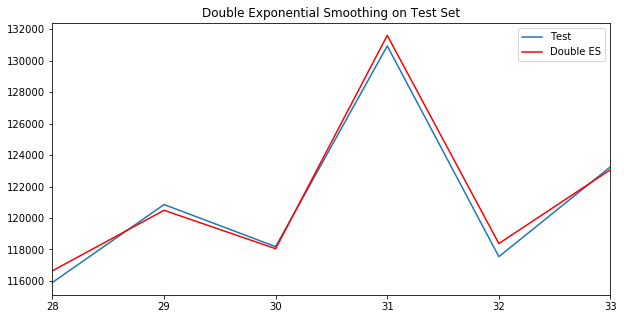

In [13]:
test.plot(figsize=(10,5), label='Test', legend=True)
es2_test.plot(figsize=(10,5), color='r', label='Double ES', legend=True)
plt.title('Double Exponential Smoothing on Test Set')
plt.show()

## Triple Exponential Smoothing

In [14]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exp_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

### Error Metrics & Test Set Plot

In [15]:
es3 = triple_exp_smoothing(train, 4, 0.1, 0.5, 0.9, 6)
es3_test = pd.Series(es3[split_ix:], index=test_ix)
es3_mae = mean_absolute_error(test, es3_test)
print('The MAE for triple exponential smoothing on the test set is %.2f' %es3_mae)

The MAE for triple exponential smoothing on the test set is 458.33


In [16]:
from sklearn.metrics import mean_squared_error
es3_mse = mean_squared_error(test, es3_test)
print('The MSE for triple exponential smoothing on the test set is %.2f' %es3_mse)

The MSE for triple exponential smoothing on the test set is 409901.11


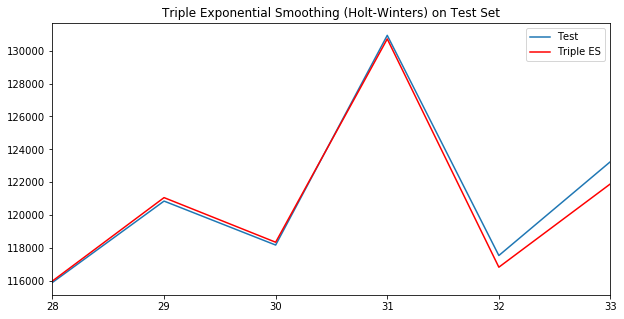

In [17]:
test.plot(figsize=(10,5), label='Test', legend=True)
es3_test.plot(figsize=(10,5), color='r', label='Triple ES', legend=True)
plt.title('Triple Exponential Smoothing (Holt-Winters) on Test Set')
plt.show()

## Method Selection

Comparing MAE among the three smoothing methods, **triple exponential smoothing** appears to give the best metric since it smoothens both the trend and seasonality component as well.

## Short-Term Prediction

We will now use the method to forecast short-term demand for the next 4 quarters.

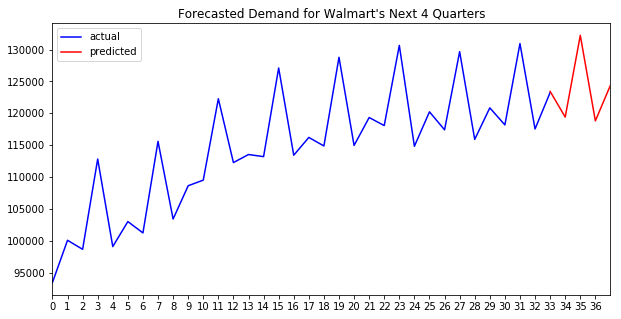

In [18]:
es3_p = triple_exp_smoothing(ts, 4, 0.1, 0.5, 0.9, 4)
es3_p = pd.Series(es3_p)
ts.plot(figsize=(10,5), color='b', label='actual', legend=True)
es3_p[33:].plot(figsize=(10,5), color='r', label='predicted', legend=True)
plt.xticks(range(0, 37, 1))
plt.title("Forecasted Demand for Walmart's Next 4 Quarters")
plt.show()